# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

Note for the marker:

1.  OOP Classes: There are some classes developed below but to keep things in sequential order we have placed in the blocks where its required and not at the bottom. It works better for functionality
2.   We have divided all sections as retrieval and classification. Please run all "Retrieval" blocks in order then run all "Classification" blocks in order.
3. Everything runs successfully under the free-tier Colab with T4 GPU (12GB of RAM and 15GB of VRAM)


# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Retrieval

### Imports

In [ ]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 16.9 MB/s eta 0:00:00


In [ ]:
!pip install rank-bm25 transformers

In [ ]:
# Standard library
import os
import json
import random
import pickle
from pathlib import Path
from datetime import datetime
import warnings

# Data stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP / retrieval
import nltk
from rank_bm25 import BM25Okapi
import faiss
from sentence_transformers import SentenceTransformer

# Progress bars
from tqdm.auto import tqdm

# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
    logging as hf_logging,
)

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)


In [ ]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# reproducibility
SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"{datetime.now()} CUDA available: {torch.cuda.is_available()}")

### Datasetup

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Set up Project folder as current working fold
Project_folder = 'drive/MyDrive/COMP90042_2025-main'
os.chdir(Project_folder)

In [ ]:
## Load all the data files

with open('data/train-claims.json') as f:
    train_claims = json.load(f)
with open('data/dev-claims.json') as f:
    dev_claims = json.load(f)
with open('data/test-claims-unlabelled.json') as f:
    test_claims = json.load(f)
with open('data/dev-claims-baseline.json','r') as f:
    dev_baseline = json.load(f)
with open('evidence.json','r') as f:
    evidence_dict = json.load(f)

train_df = pd.DataFrame([
    {'claim_id': cid, 'text': d['claim_text'], 'label': d['claim_label'], 'n_ev': len(d['evidences'])}
    for cid,d in train_claims.items()
])
dev_df   = pd.DataFrame([
    {'claim_id': cid, 'text': d['claim_text'], 'label': d['claim_label'], 'n_ev': len(d['evidences'])}
    for cid,d in dev_claims.items()
])
test_df  = pd.DataFrame([
    {'claim_id': cid, 'text': d['claim_text']}
    for cid,d in test_claims.items()
])

dev_claims_list = list(dev_claims.keys())
train_claims_list = list(train_claims.keys())
test_claims_list = list(test_claims.keys())

In [ ]:
train_df

,claim_id,text,label,n_ev
0,claim-1937,Not only is there no scientific evidence that ...,DISPUTED,3
1,claim-126,El Niño drove record highs in global temperatu...,REFUTES,2
2,claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,2
3,claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,5
4,claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,5
...,...,...,...,...
1223,claim-1504,Climate scientists say that aspects of the cas...,SUPPORTS,4
1224,claim-243,"In its 5th assessment report in 2013, the IPCC...",SUPPORTS,1
1225,claim-2302,"Since the mid 1970s, global temperatures have ...",NOT_ENOUGH_INFO,5
1226,claim-502,But abnormal temperature spikes in February an...,NOT_ENOUGH_INFO,5


In [ ]:
dev_df

,claim_id,text,label,n_ev
0,claim-752,[South Australia] has the most expensive elect...,SUPPORTS,2
1,claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,5
2,claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,2
3,claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,5
4,claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,4
...,...,...,...,...
149,claim-2400,"'To suddenly label CO2 as a ""pollutant"" is a d...",REFUTES,4
150,claim-204,"after a natural orbitally driven warming, atmo...",NOT_ENOUGH_INFO,5
151,claim-1426,Many of the world’s coral reefs are already ba...,NOT_ENOUGH_INFO,5
152,claim-698,A recent study led by Lawrence Livermore Natio...,REFUTES,1


In [ ]:
test_df

,claim_id,text
0,claim-2967,The contribution of waste heat to the global c...
1,claim-979,“Warm weather worsened the most recent five-ye...
2,claim-1609,Greenland has only lost a tiny fraction of its...
3,claim-1020,“The global reef crisis does not necessarily m...
4,claim-2599,Small amounts of very active substances can ca...
...,...,...
148,claim-293,When the measuring equipment gets old and need...
149,claim-910,"The cement, iron and steel, and petroleum refi..."
150,claim-2815,A new peer-reviewed study on Surface Warming a...
151,claim-1652,The strong CO2 effect has been observed by man...


In [ ]:
# Display a sample claim

print(f"Training claims: {len(train_claims)}")
print(f"Dev claims: {len(dev_claims)}")
print(f"Test claims: {len(test_claims)}")
sample_id, sample = next(iter(train_claims.items()))
print(f"Example claim ID: {sample_id}")
print(sample)

Training claims: 1228
Dev claims: 154
Test claims: 153
Example claim ID: claim-1937
{'claim_text': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.', 'claim_label': 'DISPUTED', 'evidences': ['evidence-442946', 'evidence-1194317', 'evidence-12171']}


### Functions

In [ ]:
R2 = lambda x : round(x, 2)
R = lambda x: round(x, 2)

get_only_evi = lambda inlist : [tup[0] for tup in inlist]

# get_claim = lambda claim_id, flag = 1:  if flag == 1  else dev_claims[claim_id]["claim_text"]

def get_claim(claim_id, flag = 1):
    if flag == 1:
        return train_claims[claim_id]["claim_text"]
    elif flag == 2:
        return dev_claims[claim_id]["claim_text"]
    elif flag == 3:
        return test_claims[claim_id]["claim_text"]

# get_evidence = lambda claim_id, flag = 1: train_claims[claim_id]["claim_text"] if flag == 1  else dev_claims[claim_id]["claim_text"]

dev_claims_list = list(dev_claims.keys())


def claim_report(true_evi, pred_evi):
  report = {}
  report["True Positive Count"] = len([this_evi for this_evi in pred_evi if this_evi in true_evi])
  report["True Positive %"] = R2(100*report["True Positive Count"]/len(pred_evi))
  report["Total True Evidences"] = len(true_evi)
  report["Total Predicted"] = len(pred_evi)
  report["% of True found in Predicted"] = R2(100*report["True Positive Count"]/len(true_evi))
  rank  = 1
  all_ranks = []
  for this_candidate in pred_evi:
    if this_candidate in true_evi:
      all_ranks.append(rank)
    rank += 1
  report["Ranks"] = all_ranks
  if(all_ranks):
    report["Mean Rank"] = R2(float(np.mean(all_ranks)))
    report["Median Rank"] = R2(float(np.median(all_ranks)))
  return report

def get_evidence(claim_id, flag = 1):
  if flag == 1:
    return dict(zip(train_claims[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in train_claims[claim_id]["evidences"]]))
  elif flag == 2:
    return dict(zip(dev_claims[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in dev_claims[claim_id]["evidences"]]))

### Generate Data

In [ ]:
import json
import random
from typing import List, Tuple


def load_climate_claims(claims_path: str) -> dict:
    """
    Returns dict: {claim_id: {"claim_text": str, "evidences": [evidence_id,…], "claim_label": label_or_None}}
    """
    with open(claims_path, 'r') as f:
        return json.load(f)

def load_evidence_passages(evidence_path: str) -> dict:
    """
    Returns dict: {evidence_id: evidence_text}
    """
    with open(evidence_path, 'r') as f:
        return json.load(f)

def load_pointwise_data(
    claims: dict,
    evidence: dict,
    max_neg_per_pos: int = 1,
    seed: int = 42
) -> List[Tuple[str, str, int]]:
    """
    Build pointwise (claim, sentence, label) examples:
     - For each gold evidence: label=1
     - For up to max_neg_per_pos negatives per positive: label=0
    """
    random.seed(seed)
    all_eids = set(evidence.keys())
    examples = []
    for cid, entry in tqdm(claims.items(), desc=f"Loading Pointwise Data ..."):
        claim_text = entry['claim_text']
        pos_eids   = entry.get('evidences', [])
        neg_pool   = list(all_eids - set(pos_eids))
        # Positive examples
        for peid in pos_eids:
            if peid in evidence:
                examples.append((claim_text, evidence[peid], 1))
                # sample negatives
                for neg_eid in random.sample(neg_pool, k=min(max_neg_per_pos, len(neg_pool))):
                    examples.append((claim_text, evidence[neg_eid], 0))
    return examples

def load_pairwise_data(
    claims: dict,
    evidence: dict,
    negs_per_pos: int = 1,
    seed: int = 42
) -> List[Tuple[str, str, str]]:
    """
    Build pairwise (claim, pos_sentence, neg_sentence) examples:
     for each positive, sample negs_per_pos negatives.
    """
    random.seed(seed)
    all_eids = set(evidence.keys())
    triplets = []
    for cid, entry in tqdm(claims.items(), desc=f"Loading Pairwise Data ..."):
        claim_text = entry['claim_text']
        pos_eids   = entry.get('evidences', [])
        neg_pool   = list(all_eids - set(pos_eids))
        for peid in pos_eids:
            if peid in evidence and len(neg_pool) >= negs_per_pos:
                negs = random.sample(neg_pool, k=negs_per_pos)
                for ne in negs:
                    triplets.append((claim_text, evidence[peid], evidence[ne]))
    return triplets

In [ ]:
# load raw JSON
train_claims = load_climate_claims('data/train-claims.json')
evidence     = evidence_dict # load_evidence_passages('data/evidence.json')

# build pointwise dataset (1 negative per positive)
pointwise = load_pointwise_data(train_claims, evidence, max_neg_per_pos=1)
print(f"Built {len(pointwise)} pointwise examples (claim, sentence, label)")

# build pairwise dataset (2 negatives per positive)
pairwise  = load_pairwise_data(train_claims, evidence, negs_per_pos=2)
print(f"Built {len(pairwise)} pairwise examples (claim, pos, neg)")


Loading Pointwise Data ...: 100%|██████████| 1228/1228 [05:24<00:00,  3.79it/s]


Built 8244 pointwise examples (claim, sentence, label)


Loading Pairwise Data ...: 100%|██████████| 1228/1228 [05:22<00:00,  3.81it/s]

Built 8244 pairwise examples (claim, pos, neg)


In [ ]:
print(f"pointwise sample: {pointwise[10]}")
print()
print(f"pairwise  sample: {pairwise[10]}")

pointwise sample: ('In 1946, PDO switched to a cool phase.', 'There is evidence of reversals in the prevailing polarity (meaning changes in cool surface waters versus warm surface waters within the region) of the oscillation occurring around 1925, 1947, and 1977; the last two reversals corresponded with dramatic shifts in salmon production regimes in the North Pacific Ocean.', 1)

pairwise  sample: ('In 1946, PDO switched to a cool phase.', 'There is evidence of reversals in the prevailing polarity (meaning changes in cool surface waters versus warm surface waters within the region) of the oscillation occurring around 1925, 1947, and 1977; the last two reversals corresponded with dramatic shifts in salmon production regimes in the North Pacific Ocean.', '2 - Age must be above 21 years old and fully capable of handling a weapon.')


In [ ]:
with open('saves/pointwise_train_data_X.pkl', 'wb') as f:
    pickle.dump(pointwise, f)

with open('saves/pairwise_train_data_X.pkl', 'wb') as f:
    pickle.dump(pairwise, f)

In [ ]:
with open('saves/pointwise_train_data_X.pkl', 'rb') as f:
    pointwise_train = pickle.load(f)
with open('saves/pairwise_train_data_X.pkl', 'rb') as f:
    pairwise_train = pickle.load(f)

In [ ]:
dev_claims = load_climate_claims('data/dev-claims.json')   # ← use dev, not train
evidence     = evidence_dict # load_evidence_passages('data/evidence.json')

pointwise_dev = load_pointwise_data(dev_claims, evidence, max_neg_per_pos=1)
print(f"Dev examples: {len(pointwise_dev):,} pairs (1 pos + 1 neg each)")

pairwise_dev  = load_pairwise_data(dev_claims, evidence, negs_per_pos=2)
print(f"Built {len(pairwise_dev)} pairwise examples (claim, pos, neg)")

Loading Pointwise Data ...: 100%|██████████| 154/154 [00:40<00:00,  3.84it/s]


Dev examples: 982 pairs (1 pos + 1 neg each)


Loading Pairwise Data ...: 100%|██████████| 154/154 [00:40<00:00,  3.83it/s]

Built 982 pairwise examples (claim, pos, neg)


In [ ]:
with open('saves/pointwise_dev_data_X.pkl', 'wb') as f:
    pickle.dump(pointwise_dev, f)

with open('saves/pairwise_dev_data_X.pkl', 'wb') as f:
    pickle.dump(pairwise_dev, f)

In [ ]:
with open('saves/pointwise_dev_data_X.pkl', 'rb') as f:
    pointwise_dev  = pickle.load(f)
with open('saves/pairwise_dev_data_X.pkl', 'rb') as f:
    pairwise_dev = pickle.load(f)

## Classification

### Data Load and Functions
NOTE: Block 1 for Classification

In [ ]:
DATA, SAVES = Path("data"), Path("output")

#helper functions
def build_sentence_masks(text, tok, max_len, max_sent):
    sents = text.split(". ")[:max_sent]
    enc   = tok(text, truncation=True, max_length=max_len,
                return_offsets_mapping=True, add_special_tokens=False)
    mask = np.zeros((max_sent, max_len), dtype=bool)
    char = 0
    for si, s in enumerate(sents):
        a, b = char, char + len(s)
        for ti,(L,R) in enumerate(enc["offset_mapping"]):
            if ti>=max_len: break
            if L>=a and R<=b:
                mask[si,ti] = True
        char = b + 2
    return mask

def strip_scores(top5_raw):
    return {cid: [triple[0] for triple in triples]
            for cid, triples in top5_raw.items()}
#dataset class
class ClaimEvidenceDataset(Dataset):
    def __init__(self, claim_dict, top5_dict, evid_dict, tok,
                 mode="gold", k_ret=2,
                 max_len=512, max_claim_sent=1, max_evid_sent=5,
                 label_map=None):
        self.data = []
        for cid, meta in claim_dict.items():
            claim = meta["claim_text"]
            gold  = meta.get("evidences", [])
            ret   = top5_dict.get(cid, [])
            if   mode=="gold":      evid_ids = gold
            elif mode=="retrieved": evid_ids = ret
            elif mode=="hybrid":    evid_ids = list(dict.fromkeys(gold + ret[:k_ret]))
            else: raise ValueError(mode)

            evid_txt = " ".join(evid_dict[e] for e in evid_ids)
            enc = tok.encode_plus(
                claim, evid_txt,
                truncation=True, max_length=max_len,
                padding="max_length"
            )
            item = {k: torch.tensor(v) for k,v in enc.items()}
            item["sent_mask_claim"] = torch.tensor(
                build_sentence_masks(claim, tok, max_len, max_claim_sent))
            item["sent_mask_evid"]  = torch.tensor(
                build_sentence_masks(evid_txt, tok, max_len, max_evid_sent))
            item["claim_id"] = cid
            if label_map and "claim_label" in meta:
                item["labels"] = torch.tensor(label_map[meta["claim_label"]])
            self.data.append(item)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]



## retrieved top 5 from retrieval
with open(SAVES/"dev_distilbert_pairwise_001-Top5.pkl","rb") as f:
    dev_top5 = pickle.load(f)
with open(SAVES/"train_distilbert_pairwise_001-Top5.pkl","rb") as f:
    train_top5 = pickle.load(f)
with open(SAVES/"test_distilbert_pairwise_001-Top5.pkl","rb") as f:
    test_top5 = pickle.load(f)

LABEL2ID = {
    "SUPPORTS":        0,
    "REFUTES":         1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED":        3,
}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}



# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Retrieval

### Stage 1: Candidates Selection

In [ ]:
class RetrievalStage1:
    def __init__(
        self,
        evidence_dict: dict,
        sbert_model: str = 'all-MiniLM-L6-v2',
        bm25_tokenizer=nltk.word_tokenize,
        use_gpu: bool = True,
        emb_file: str = 'saves/evidence_embeddings_X.npy',
        ids_file: str = 'saves/evidence_ids_X.pkl',
        index_file: str = 'saves/evidence_index_X.faiss',
        only_dense = False
    ):
        """
        evidence_dict : {evidence_id -> evidence_text}
        sbert_model   : HuggingFace/Sentence-Transformers model name
        bm25_tokenizer: function to tokenize for BM25
        use_gpu       : whether to push SBERT to 'cuda'
        emb_file      : path for numpy embeddings
        ids_file      : path for pickle’d id list
        index_file    : path for faiss index
        """
        self.evidence_dict = evidence_dict
        self.only_dense = only_dense
        if (not self.only_dense):
          # BM25 setup
          self.doc_ids   = list(evidence_dict.keys())
          # self.documents = [evidence_dict[eid] for eid in self.doc_ids]
          self.documents = []
          for eid in tqdm(self.doc_ids, desc=f"Setting up evidence documents ..."):
            self.documents.append(evidence_dict[eid])
          nltk.download('punkt', quiet=True)
          # tokenized = [bm25_tokenizer(doc.lower()) for doc in self.documents]
          tokenized = []
          for doc in tqdm(self.documents, desc=f"Tokenizing ..."):
            tokenized.append(bm25_tokenizer(doc.lower()))

          self.bm25 = BM25Okapi(tokenized)

        # SBERT + FAISS
        device = 'cuda' if use_gpu and __import__('torch').cuda.is_available() else 'cpu'
        self.embedder = SentenceTransformer(sbert_model, device=device)

        # preserve file paths
        self.emb_file   = emb_file
        self.ids_file   = ids_file
        self.index_file = index_file

        if os.path.exists(self.emb_file) and os.path.exists(self.ids_file) and os.path.exists(self.index_file):
            # reload from disk
            print(f"Saved files found. Loading files ...")
            self.evidence_ids = pickle.load(open(self.ids_file, 'rb'))
            self.embeddings   = np.load(self.emb_file)
            self.index        = faiss.read_index(self.index_file)
            print(f"Loaded from disk: {self.emb_file}, {self.ids_file}, {self.index_file}")
        else:
            print(f"No saved file found. Generating files ...")
            # encode & build
            self.evidence_ids = self.doc_ids
            self.embeddings   = self.embedder.encode(
                self.documents,
                batch_size=256,
                convert_to_numpy=True,
                show_progress_bar=True
            )
            faiss.normalize_L2(self.embeddings)
            dim = self.embeddings.shape[1]
            self.index = faiss.IndexFlatIP(dim)
            self.index.add(self.embeddings)

            # persist
            np.save(self.emb_file, self.embeddings)
            pickle.dump(self.evidence_ids, open(self.ids_file, 'wb'))
            faiss.write_index(self.index, self.index_file)
            print(f"New Files saved: {self.emb_file}, {self.ids_file}, {self.index_file}")

    def lexical_retrieval(self, query: str, top_n: int = 5, show_value: bool = False) -> List[Tuple[str,str,float]]:
        tokens = query.lower().split()
        scores = self.bm25.get_scores(tokens)
        topi   = np.argsort(scores)[::-1][:top_n]
        out = [(self.doc_ids[i], float(scores[i])) for i in topi]  ## self.documents[i],
        return out if show_value else [eid for eid,_ in out]

    def dense_retrieval(self, query: str, top_n: int = 5, show_value: bool = False) -> List[Tuple[str,str,float]]:
        qvec = self.embedder.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(qvec)
        D, I = self.index.search(qvec, top_n)
        out = [
            (self.evidence_ids[int(idx)],
            #  self.evidence_dict[self.evidence_ids[int(idx)]],
             float(D[0][r]))
            for r, idx in enumerate(I[0])
        ]
        return out if show_value else [eid for eid,_ in out]

    def retrieve_hybrid(self, query: str, k_bm25: int = 5, k_dense: int = 5, k_final: int = 5) -> List[Tuple[str,str,float]]:
        bm25_hits  = self.lexical_retrieval(query, k_bm25, show_value=True)
        dense_hits = self.dense_retrieval(query, k_dense, show_value=True)
        combined = {}
        for eid, _, sc in bm25_hits + dense_hits:
            combined[eid] = max(combined.get(eid, -1e9), sc)
        top = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k_final]
        return [(eid, self.evidence_dict[eid], sc) for eid, sc in top]

    def retrieve(self, query: str, k: int = 5, mode: str = 'dense', show_value: bool = False):
        if mode == 'lexical':
            return self.lexical_retrieval(query, k, show_value)
        if mode == 'dense':
            return self.dense_retrieval(query, k, show_value)
        if mode == 'hybrid':
            return self.retrieve_hybrid(query, k, k, k)
        raise ValueError(f"Unknown mode {mode}")


In [ ]:
retriever = RetrievalStage1(evidence_dict)

Tokenizing ...: 100%|██████████| 1208827/1208827 [02:47<00:00, 7226.24it/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

No saved file found. Generating files ...


Batches:   0%|          | 0/4722 [00:00<?, ?it/s]

New Files saved: saves/evidence_embeddings_X.npy, saves/evidence_ids_X.pkl, saves/evidence_index_X.faiss


In [ ]:
print(get_claim("claim-2449"))
print()
for evi, evi_text in get_evidence("claim-2449", 1).items():
    print(f"{evi}: {evi_text}")
print()

"January 2008 capped a 12 month period of global temperature drops on all of the major well respected indicators.

evidence-1010750: With average temperature +8.1 °C (47 °F).
evidence-91661: The Iranian / Persian calendar, currently used in Iran and Afghanistan, also has 12 months.
evidence-722725: All of these events can have wide variations of more than a month from year to year.
evidence-554161: Its average duration is 365.256363004 days (365 d 6 h 9 min 9.76 s) (at the epoch J2000.0 = January 1, 2000, 12:00:00 TT).
evidence-430839: It has a duration of approximately 354.37 days.



In [ ]:
print("Lexical Retriever:")
for evi in retriever.retrieve(get_claim("claim-2449", 1), 5, "lexical"):
    print(f"{evi}: {evidence_dict[evi]}")

Lexical Retriever:
evidence-343576: "Estimating Changes in Global Temperature since the Preindustrial Period".
evidence-814320: The solar minima in this period coincided with volcanic eruptions, which have a cooling effect on the global temperature.
evidence-898633: The 1850–1900 period is a reasonable pragmatic surrogate for preindustrial global mean temperature."
evidence-398304: The well was finally capped on 15 July 2010.
evidence-498301: The IPCC has adopted the baseline reference period 1850–1900 as an approximation of pre-industrial global mean surface temperature.


In [ ]:
print("Dense Retriever:")
for evi in retriever.retrieve(get_claim("claim-2449", 1), 5, "dense"):
    print(f"{evi}: {evidence_dict[evi]}")

Dense Retriever:
evidence-343576: "Estimating Changes in Global Temperature since the Preindustrial Period".
evidence-110980: During this period, a sharp drop in global temperatures took place.
evidence-378444: The IPCC published their "Special Report on Global Warming of 1.5 °C" on October 8, 2018.
evidence-64048: "Breaking global temperature records after Mt.
evidence-1170: Trends in global temperatures since January 1979 (the beginning of the satellite temperature record), measured in degrees Celsius per decade, at as October 31, 2019:


In [ ]:
print("Hybrid Retriever:")
for evi in retriever.retrieve(get_claim("claim-2449", 1), 5, "hybrid"):
    print(f"{evi[0]}: {evidence_dict[evi[0]]}")

Hybrid Retriever:
evidence-343576: "Estimating Changes in Global Temperature since the Preindustrial Period".
evidence-814320: The solar minima in this period coincided with volcanic eruptions, which have a cooling effect on the global temperature.
evidence-898633: The 1850–1900 period is a reasonable pragmatic surrogate for preindustrial global mean temperature."
evidence-398304: The well was finally capped on 15 July 2010.
evidence-498301: The IPCC has adopted the baseline reference period 1850–1900 as an approximation of pre-industrial global mean surface temperature.


From the table below and the diagnostics (mean rank, % of true evidences retrieved, and number of “failed” claims), the **dense** retriever is clearly superior to the pure TF–IDF (**lexical**) approach at every cutoff.

| Cutoff (Top N) | Dense: Mean Rank | Lexical: Mean Rank | Dense: % True Found | Lexical: % True Found | Dense: # Fails | Lexical: # Fails |
| -------------: | ---------------: | -----------------: | ------------------: | --------------------: | -------------: | ---------------: |
|           1000 |            133.2 |              370.3 |              89.7 % |                67.5 % |              2 |               16 |
|            500 |             90.0 |              244.0 |              83.2 % |                46.2 % |              4 |               35 |
|            100 |             24.5 |               53.2 |              61.1 % |                10.6 % |             20 |              111 |
|             50 |             14.6 |               21.6 |              52.9 % |                 5.0 % |             31 |              135 |
|             20 |              6.6 |                9.5 |              38.1 % |                 2.9 % |             53 |              143 |
|             10 |              3.7 |                6.3 |              28.4 % |                 1.6 % |             68 |              147 |
|              5 |              2.3 |                2.7 |              22.2 % |                 0.9 % |             84 |              151 |

**Which Top N is the best “sweet spot”?**

Looking for elbow where adding more candidates gives diminishing returns:

* **N=20**: Dense already recovers \~38 % of true evidences, with mean rank ≈ 6
* **N=100**: Dense already recovers \~61 % of true evidences, with mean rank ≈ 24.
* **N=500**: Dense jumps to \~83 % and only 4 misses—but it’s 5× heavier.

For a **lightweight** retrieval that still gets most evidences in, **Top 20** is a good compromise. If ultra-high recall (≈ > 80 %) and near-zero misses is critical, bump up to **Top 500**.

Hence for the rest of the code we used **Top 20** evidences from the **dense retriever** as the candidates input for the re-ranker

### Stage 2: Reranking

In [ ]:
# Hyperparameters
MODEL_NAME    = "distilbert-base-uncased"
OUTPUT_DIR    = "./distilbert-reranker-tqdm"
BATCH_SIZE    = 16
LR            = 5e-5
EPOCHS        = 6
MAX_LEN       = 128
TRAIN_FILE    = "saves/pairwise_train_data_X.pkl"
DEV_FILE      = "saves/pairwise_dev_data_X.pkl"
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pairwise data as binary classification examples
with open(TRAIN_FILE, "rb") as f:
    train_pairs = pickle.load(f)
with open(DEV_FILE, "rb") as f:
    dev_pairs = pickle.load(f)

train_texts, train_labels = [], []
for claim, pos, neg in train_pairs:
    train_texts.append((claim, pos)); train_labels.append(1)
    train_texts.append((claim, neg)); train_labels.append(0)

dev_texts, dev_labels = [], []
for claim, pos, neg in dev_pairs:
    dev_texts.append((claim, pos)); dev_labels.append(1)
    dev_texts.append((claim, neg)); dev_labels.append(0)

# Tokenizer and DataLoader
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
def encode(text_pairs, labels):
    enc = tokenizer([c for c, e in text_pairs],
                    [e for c, e in text_pairs],
                    padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return torch.utils.data.TensorDataset(enc["input_ids"], enc["attention_mask"], torch.tensor(labels))

train_dataset = encode(train_texts, train_labels)
dev_dataset   = encode(dev_texts,   dev_labels)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader    = DataLoader(dev_dataset,   batch_size=BATCH_SIZE)

# Model, optimizer, scheduler
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with tqdm
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    total_loss = 0
    for input_ids, attention_mask, labels in train_bar:
        input_ids, attention_mask, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        train_bar.set_postfix(loss=total_loss / (train_bar.n + 1))

    # Evaluation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in dev_loader:
            input_ids, attention_mask, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total * 100
    print(f"Validation Accuracy after epoch {epoch+1}: {acc:.2f}%")

# # Save model
# torch.save(model.state_dict(), f"{OUTPUT_DIR}/distilbert_tqdm.pt")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.79it/s, loss=0.0888]


Validation Accuracy after epoch 1: 97.76%


Epoch 2/6: 100%|██████████| 1031/1031 [03:03<00:00,  5.62it/s, loss=0.0195]


Validation Accuracy after epoch 2: 97.91%


Epoch 3/6: 100%|██████████| 1031/1031 [03:03<00:00,  5.62it/s, loss=0.00735]


Validation Accuracy after epoch 3: 99.19%


Epoch 4/6: 100%|██████████| 1031/1031 [03:03<00:00,  5.62it/s, loss=0.00401]


Validation Accuracy after epoch 4: 98.88%


Epoch 5/6: 100%|██████████| 1031/1031 [03:03<00:00,  5.62it/s, loss=0.00194]


Validation Accuracy after epoch 5: 98.52%


Epoch 6/6: 100%|██████████| 1031/1031 [03:03<00:00,  5.62it/s, loss=0.00116]


Validation Accuracy after epoch 6: 98.83%


In [ ]:
# # 7) Save model
torch.save(model.state_dict(), "saves/distilbert_pairwise_X.pt")
print("Finished training – model saved to saves/distilbert_pairwise_X.pt")

Finished training – model saved to saves/distilbert_pairwise_X.pt


In [ ]:
retriever = RetrievalStage1(
    evidence_dict,
    emb_file   = "saves/evidence_embeddings_X.npy",
    ids_file   = "saves/evidence_ids_X.pkl",
    index_file = "saves/evidence_index_X.faiss",
    only_dense = True
)

Saved files found. Loading files ...
Loaded from disk: saves/evidence_embeddings_X.npy, saves/evidence_ids_X.pkl, saves/evidence_index_X.faiss


In [ ]:
# Setup
MAX_LEN        = 128
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_X.pt"

# Reload trained DistilBERT classifier
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model     = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)
state     = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# Inference helper (returns positive‐class logit)
def get_bert_scores(claim_text, candidate_ids):
    scores = {}
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits
        scores[eid] = logits[0,1].item()  # positive‐class logit
    return scores

# Fusion sweep
TOP_N  = 20
K      = 5
alphas = np.linspace(0,1,11)

best_alpha, best_f1 = None, -1.0
results = {}

# for alpha in tqdm(alphas):
for alpha in alphas:
    y_true, y_pred = [], []
    for cid in tqdm(dev_claims_list, desc=f"Sweeping α={alpha:.1f}"):
        claim_text    = get_claim(cid,2)
        # dense_scores  = dense_retrieval(claim_text, top_n=TOP_N, show_value=True)
        dense_scores  = retriever.retrieve(claim_text, TOP_N, "dense", True)
        # print(f"dense_scores = {dense_scores}")
        cands         = [eid for eid,_ in dense_scores]
        dense_map     = dict(dense_scores)
        bert_map      = get_bert_scores(claim_text, cands)

        # fuse & rank
        fused = [(eid, alpha*dense_map[eid] + (1-alpha)*bert_map[eid])
                  for eid in cands]
        ranked = [eid for eid,_ in sorted(fused, key=lambda x:x[1], reverse=True)]
        topk   = set(ranked[:K])
        gold   = set(get_evidence(cid,2).keys())

        # flatten for metrics
        for eid in cands:
            y_true.append(1 if eid in gold else 0)
            y_pred.append(1 if eid in topk else 0)

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    results[alpha] = {"precision":p, "recall":r, "f1":f}
    if f>best_f1:
        best_f1, best_alpha = f, alpha

# Print sweep results
print("α sweep results:")
for α, m in results.items():
    print(f"α={α:.1f} → P={m['precision']:.3f}, R={m['recall']:.3f}, F1={m['f1']:.3f}")
print(f"\nBest α={best_alpha:.1f} with F1={best_f1:.3f}")


Sweeping α=1.0: 100%|██████████| 154/154 [00:49<00:00,  3.12it/s]

α sweep results:
α=0.0 → P=0.078, R=0.351, F1=0.128
α=0.1 → P=0.096, R=0.433, F1=0.157
α=0.2 → P=0.114, R=0.515, F1=0.187
α=0.3 → P=0.122, R=0.550, F1=0.200
α=0.4 → P=0.125, R=0.561, F1=0.204
α=0.5 → P=0.131, R=0.591, F1=0.215
α=0.6 → P=0.134, R=0.602, F1=0.219
α=0.7 → P=0.134, R=0.602, F1=0.219
α=0.8 → P=0.135, R=0.608, F1=0.221
α=0.9 → P=0.134, R=0.602, F1=0.219
α=1.0 → P=0.123, R=0.556, F1=0.202

Best α=0.8 with F1=0.221


## Classification

NOTE: Block 2 for Classification

In [ ]:
retriever = RetrievalStage1(
    evidence_dict,
    emb_file   = "saves/evidence_embeddings_X.npy",
    ids_file   = "saves/evidence_ids_X.pkl",
    index_file = "saves/evidence_index_X.faiss",
    only_dense = True
)

Saved files found. Loading files ...
Loaded from disk: saves/evidence_embeddings_X.npy, saves/evidence_ids_X.pkl, saves/evidence_index_X.faiss


In [ ]:
# class for MLA pooling
class MLAPool(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.token_att   = nn.Linear(hidden, 1)
        self.sent_att    = nn.Linear(hidden, 1)
        self.layer_w     = nn.Parameter(torch.zeros(num_layers))
        self.temp        = nn.Parameter(torch.ones(1))

    def forward(self, layers, sent_mask):
        L = self.num_layers
        stack = torch.stack(layers[-L:], dim=1)            # [B,L,T,H]
        w     = torch.softmax(self.temp * self.layer_w, 0) # [L]
        h     = (w[None,:,None,None] * stack).sum(1)       # [B,T,H]

        B,S,T = sent_mask.shape
        h_exp   = h.unsqueeze(1).expand(-1,S,-1,-1)       # [B,S,T,H]
        tok_scores = self.token_att(h_exp).squeeze(-1)    # [B,S,T]
        tok_scores = tok_scores.masked_fill(~sent_mask, -1e4)
        tok_w   = torch.softmax(tok_scores, -1).unsqueeze(-1)  # [B,S,T,1]
        sent_vec = (tok_w * h_exp).sum(2)                 # [B,S,H]

        sent_scores = self.sent_att(sent_vec).squeeze(-1) # [B,S]
        valid_sent  = sent_mask.any(-1)                   # [B,S]
        sent_scores = sent_scores.masked_fill(~valid_sent, -1e4)
        sent_w   = torch.softmax(sent_scores, -1).unsqueeze(-1) # [B,S,1]
        doc_vec  = (sent_w * sent_vec).sum(1)             # [B,H]
        return doc_vec

#GAT inspired graph fusion
class TinyBERT_GraphFusion(nn.Module):
    def __init__(self, model_name, num_labels, num_layers=4, max_evid_sent=5):
        super().__init__()
        self.bert      = AutoModel.from_pretrained(model_name,
                                                   output_hidden_states=True)
        H              = self.bert.config.hidden_size
        self.mla_claim = MLAPool(H, num_layers)
        self.mla_evid  = MLAPool(H, num_layers)

        # stacked "graph" self-attentions with residual+LayerNorm
        self.node_attn1 = nn.MultiheadAttention(embed_dim=H,
                                                num_heads=8,
                                                batch_first=True)
        self.norm1      = nn.LayerNorm(H)
        self.node_attn2 = nn.MultiheadAttention(embed_dim=H,
                                                num_heads=8,
                                                batch_first=True)
        self.norm2      = nn.LayerNorm(H)

        # classifier input size = (1 + max_evid_sent) * H
        self.classifier = nn.Sequential(
            nn.Linear((1 + max_evid_sent) * H, 256),
            nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )
        self.max_evid_sent = max_evid_sent

    def forward(self,
                input_ids,
                attention_mask,
                token_type_ids,
                sent_mask_claim,   # [B, 1, T]
                sent_mask_evid):   # [B, S, T]

        out = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        output_hidden_states=True)
        hs = out.hidden_states   # list of length num_layers: each [B,T,H]

        # 1) Pool claim → [B,H]
        claim_vec = self.mla_claim(hs, sent_mask_claim)

        # 2) Pool evidence sentences → [B, S, H]
        B, S, T = sent_mask_evid.shape
        evid_vecs = []
        for i in range(S):
            mask_i = sent_mask_evid[:, i, :].unsqueeze(1)  # [B,1,T]
            vec_i  = self.mla_evid(hs, mask_i)              # [B,H]
            evid_vecs.append(vec_i)
        evid_vecs = torch.stack(evid_vecs, dim=1)          # [B,S,H]

        # 3) Build node sequence [B, N, H] where N = 1+S
        nodes = torch.cat([claim_vec.unsqueeze(1), evid_vecs], dim=1)

        # 4) First self-attention + residual + norm → [B, N, H]
        x1, _ = self.node_attn1(nodes, nodes, nodes)
        x1     = self.norm1(x1 + nodes)

        # 5) Second self-attention + residual + norm → [B, N, H]
        x2, _ = self.node_attn2(x1, x1, x1)
        fused_nodes = self.norm2(x2 + x1)

        # 6) Flatten and classify
        feat = fused_nodes.reshape(B, -1)  # [B, N*H]
        return self.classifier(feat)       # [B, num_labels]

#we use tiny bert
tok = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_6L_768D")


config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/287M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/287M [00:00<?, ?B/s]

Epoch 1 | train_loss=0.9161 | dev_acc=35.71% | dev_f1=20.89% | time=67.7s
Epoch 2 | train_loss=0.7161 | dev_acc=43.51% | dev_f1=27.30% | time=66.3s
Epoch 3 | train_loss=0.7491 | dev_acc=51.95% | dev_f1=35.94% | time=66.7s
Epoch 4 | train_loss=0.5598 | dev_acc=48.70% | dev_f1=37.42% | time=66.4s
Epoch 5 | train_loss=0.4144 | dev_acc=52.60% | dev_f1=42.66% | time=66.7s

Total training time: 5.9 minutes (355s)


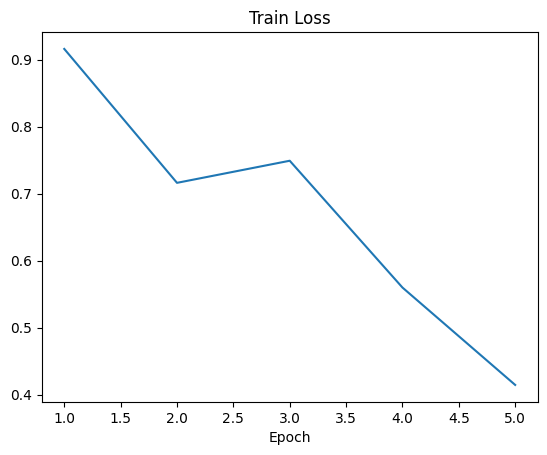

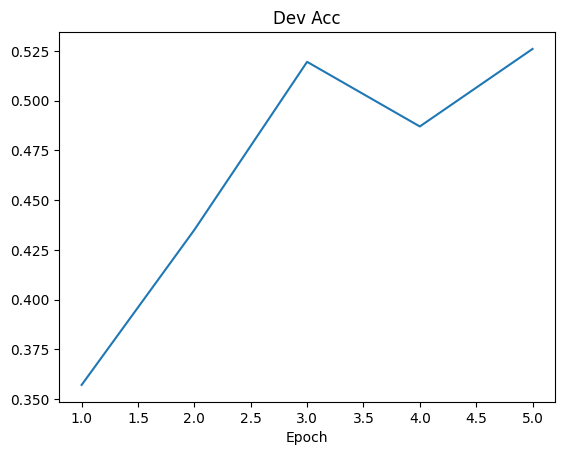

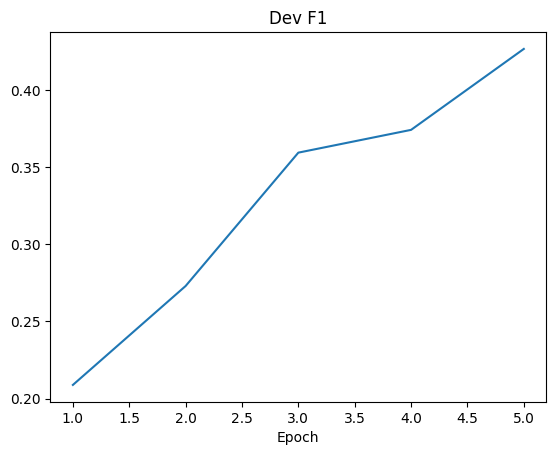


Final Dev Classification Report:

                 precision    recall  f1-score   support

       SUPPORTS      0.621     0.794     0.697        68
        REFUTES      0.552     0.593     0.571        27
NOT_ENOUGH_INFO      0.667     0.195     0.302        41
       DISPUTED      0.115     0.167     0.136        18

       accuracy                          0.526       154
      macro avg      0.489     0.437     0.427       154
   weighted avg      0.562     0.526     0.504       154



In [ ]:


# hyper paramerters
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_EPOCHS = 5        # 2 gold warm-up, 3 hybrid
PATIENCE   = 1
BATCH_SIZE = 16

# logging lists
epochs_list, train_loss_list = [], []
dev_acc_list, dev_f1_list     = [], []

#datalaoder
def get_loader(split, epoch=None):
    if split=="train":
        mode, k = ("gold",0) if epoch<=2 else ("hybrid",2)
        ds = ClaimEvidenceDataset(
            train_claims, train_top5, evidence_dict, tok,
            mode=mode, k_ret=k,
            max_claim_sent=1, max_evid_sent=5,
            label_map=LABEL2ID
        )
        return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
    dct = dev_claims if split=="dev" else test_claims
    t5  = dev_top5     if split=="dev" else test_top5
    use_labels = (split=="dev")
    ds = ClaimEvidenceDataset(
        dct, t5, evidence_dict, tok,
        mode="retrieved",
        max_claim_sent=1, max_evid_sent=5,
        label_map=LABEL2ID if use_labels else None
    )
    return DataLoader(ds, batch_size=32)

# calling the model the defining optimizer and loss
model     = TinyBERT_GraphFusion("huawei-noah/TinyBERT_General_6L_768D",
                                 num_labels=len(LABEL2ID)).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# training loop
import time


best_f1, wait = 0.0, 0
total_start = time.time()

for ep in range(1, MAX_EPOCHS+1):
    epoch_start = time.time()
    # prepare train loader & scheduler
    train_dl = get_loader("train", ep)
    steps    = len(train_dl)
    sched    = get_linear_schedule_with_warmup(
                   optimizer,
                   num_warmup_steps=int(0.1*steps),
                   num_training_steps=steps
               )

    # --- TRAIN
    model.train()
    epochs_list.append(ep)
    tot_loss, n = 0.0, 0
    for b in train_dl:
        inputs = [b[k].to(DEVICE) for k in
                  ["input_ids","attention_mask","token_type_ids",
                   "sent_mask_claim","sent_mask_evid"]]
        labels = b["labels"].to(DEVICE)

        logits = model(*inputs)
        loss   = criterion(logits, labels)

        loss.backward()
        optimizer.step(); sched.step(); optimizer.zero_grad()

        tot_loss += loss.item() * labels.size(0)
        n       += labels.size(0)

    train_loss = tot_loss / n
    train_loss_list.append(train_loss)

    # --- DEV-eval
    dev_dl = get_loader("dev")
    model.eval()
    y_t, y_p = [], []
    with torch.no_grad():
        for b in dev_dl:
            inputs = [b[k].to(DEVICE) for k in
                      ["input_ids","attention_mask","token_type_ids",
                       "sent_mask_claim","sent_mask_evid"]]
            labels = b["labels"].to(DEVICE)

            logits = model(*inputs)
            preds  = logits.argmax(1)

            y_t.extend(labels.cpu().tolist())
            y_p.extend(preds.cpu().tolist())

    dev_acc = accuracy_score(y_t, y_p)
    dev_f1  = f1_score(y_t, y_p, average="macro")
    dev_acc_list.append(dev_acc)
    dev_f1_list.append(dev_f1)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {ep} | train_loss={train_loss:.4f} | "
          f"dev_acc={dev_acc:.2%} | dev_f1={dev_f1:.2%} | "
          f"time={epoch_time:.1f}s")

    # early stopping
    if dev_f1 > best_f1:
        best_f1, wait = dev_f1, 0
        torch.save(model.state_dict(), SAVES/"tinybert_graphfusion_best.pt")
    else:
        wait += 1
        if wait > PATIENCE:
            print("Early stopping.")
            break

total_time = time.time() - total_start
print(f"\nTotal training time: {total_time/60:.1f} minutes ({total_time:.0f}s)")


# plot
df = pd.DataFrame({
    "epoch": epochs_list,
    "train_loss": train_loss_list,
    "dev_accuracy": dev_acc_list,
    "dev_macro_f1": dev_f1_list
})
# df.to_csv("training_metrics_graphfusion.csv", index=False)
# print("Saved training_metrics_graphfusion.csv")

plt.figure(); plt.plot(epochs_list, train_loss_list);  plt.title("Train Loss"); plt.xlabel("Epoch"); plt.show()
plt.figure(); plt.plot(epochs_list, dev_acc_list);     plt.title("Dev Acc");   plt.xlabel("Epoch"); plt.show()
plt.figure(); plt.plot(epochs_list, dev_f1_list);      plt.title("Dev F1");    plt.xlabel("Epoch"); plt.show()

# final dev
model.load_state_dict(torch.load(SAVES/"tinybert_graphfusion_best.pt", map_location=DEVICE))
y_t, y_p = [], []
with torch.no_grad():
    for b in get_loader("dev"):
        inputs = [b[k].to(DEVICE) for k in
                  ["input_ids","attention_mask","token_type_ids",
                   "sent_mask_claim","sent_mask_evid"]]
        logits = model(*inputs)
        preds  = logits.argmax(1).cpu().tolist()
        y_p.extend(preds)
        y_t.extend(b["labels"].tolist())

print("\nFinal Dev Classification Report:\n")
print(classification_report(
    y_t, y_p,
    target_names=[l for l,_ in sorted(LABEL2ID.items(), key=lambda x:x[1])],
    digits=3
))


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Retrieval

In [ ]:
retriever = RetrievalStage1(
    evidence_dict,
    emb_file   = "saves/evidence_embeddings_X.npy",
    ids_file   = "saves/evidence_ids_X.pkl",
    index_file = "saves/evidence_index_X.faiss",
    only_dense = True
)

Saved files found. Loading files ...
Loaded from disk: saves/evidence_embeddings_X.npy, saves/evidence_ids_X.pkl, saves/evidence_index_X.faiss


In [ ]:
# Setup and load your trained DistilBERT reranker
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_X.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Fused reranker with alpha = 0.8
ALPHA = 0.8
TOP_N = 20   # Stage 1 retrieval cutoff

def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N, max_len=MAX_LEN):
    # Get dense scores
    # dense_scores = dense_retrieval(claim_text, top_n=top_n, show_value=True)
    dense_scores = retriever.retrieve(claim_text, top_n, show_value=True)
    candidate_ids = [eid for eid, _ in dense_scores]
    dense_map = {eid: score for eid, score in dense_scores}
    # Get BERT (DistilBERT) scores
    bert_map = {}
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text, sent,
            padding="max_length", truncation=True, max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**enc).logits
        bert_map[eid] = logits[0, 1].item()
    # Fuse and sort
    fused = [
        (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
        for eid in candidate_ids
    ]
    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in fused_sorted]

# Evaluation using fused reranker
K = 5  # final top-K

y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 2)
    ranked = fused_rerank_with_alpha(claim_text)
    pred_topK = set(ranked[:K])
    gold_ids = set(get_evidence(cid, 2).keys())
    # per-claim report
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)
    # flatten for overall metrics
    for eid in ranked:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

Evaluating fused reranker: 100%|██████████| 154/154 [00:49<00:00,  3.14it/s]


Precision:           0.1351
Recall:              0.6082
F1 Score:            0.2210
Confusion Matrix:
[[2243  666]
 [  67  104]]
Avg Mean Rank (within Top 20): 2.72
Avg % True@5:            24.03%


### Test set

Saving the Top 5 evidences per claim for classification model input

In [ ]:
# Setup and load trained DistilBERT reranker
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_X.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Fusion parameters
ALPHA     = 0.8
TOP_N     = 20   # Stage 1 retrieval cutoff
MAX_LEN   = 128
K         = 5    # final top-K after reranking
SAVE_PRED = True # flag to save predictions
OUTPUT_PATH = "output/test_distilbert_pairwise_001-Top5.pkl"

# fused reranker
def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N):
    dense_scores = retriever.retrieve(claim_text, top_n, "dense", True) #
    cands        = [eid for eid, _ in dense_scores]
    dense_map    = dict(dense_scores)
    bert_map     = {}
    for eid in cands:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text, sent,
            padding="max_length", truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**enc).logits
        bert_map[eid] = logits[0, 1].item()
    fused = [
        (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
        for eid in cands
    ]
    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in fused_sorted]

# Evaluation loop
y_true = []
y_pred = []
results = []
predictions = {}

for cid in tqdm(test_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 3)
    ranked     = fused_rerank_with_alpha(claim_text)
    pred_topK  = ranked[:K]
    # gold_ids   = set(get_evidence(cid, 1).keys())

    # save predicted top-K if flag is set
    if SAVE_PRED:
        predictions[cid] = pred_topK

    # per-claim metrics
    # report = claim_report(gold_ids, pred_evi=set(pred_topK))
    # results.append(report)

    # # flatten for overall metrics
    # for eid in ranked:
    #     y_true.append(1 if eid in gold_ids else 0)
    #     y_pred.append(1 if eid in pred_topK else 0)

# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

# 4) Compute & print metrics
# precision = precision_score(y_true, y_pred)
# recall    = recall_score(y_true, y_pred)
# f1        = f1_score(y_true, y_pred)
# cm        = confusion_matrix(y_true, y_pred)
# mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
# mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
# mean_of_mean_rank = np.mean(mean_rank_list)

# print(f"\nPrecision:           {precision:.4f}")
# print(f"Recall:              {recall:.4f}")
# print(f"F1 Score:            {f1:.4f}")
# print("Confusion Matrix:")
# print(cm)
# print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
# print(f"Avg % True@{K}:            {mean_recall:.2f}%")

# Save predictions to pickle
if SAVE_PRED:
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    with open(OUTPUT_PATH, "wb") as f:
        pickle.dump(predictions, f)
    print(f"Saved Top-{K} predictions to {OUTPUT_PATH}")

Evaluating fused reranker: 100%|██████████| 153/153 [00:48<00:00,  3.18it/s]


Saved Top-5 predictions to output/test_distilbert_pairwise_001-Top5.pkl


### Dev set

Saving the Top 5 evidences per claim for classification model input

In [ ]:
# Setup and load trained DistilBERT reranker
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_X.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Fusion parameters
ALPHA     = 0.8
TOP_N     = 20   # Stage 1 retrieval cutoff
MAX_LEN   = 128
K         = 5    # final top-K after reranking
SAVE_PRED = True # flag to save predictions
OUTPUT_PATH = "output/dev_distilbert_pairwise_001-Top5.pkl"

# def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N):
#     dense_scores = dense_retrieval(claim_text, top_n=top_n, show_value=True)
#     cands        = [eid for eid, _ in dense_scores]
#     dense_map    = dict(dense_scores)
#     bert_map     = {}
#     for eid in cands:
#         sent = evidence_dict[eid]
#         enc = tokenizer(
#             claim_text, sent,
#             padding="max_length", truncation=True, max_length=MAX_LEN,
#             return_tensors="pt"
#         ).to(DEVICE)
#         with torch.no_grad():
#             logits = model(**enc).logits
#         bert_map[eid] = logits[0, 1].item()
#     fused = [
#         (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
#         for eid in cands
#     ]
#     fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
#     return [eid for eid, _ in fused_sorted]

# Evaluation loop
y_true = []
y_pred = []
results = []
predictions = {}

for cid in tqdm(dev_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 2)
    ranked     = fused_rerank_with_alpha(claim_text)
    pred_topK  = ranked[:K]
    gold_ids   = set(get_evidence(cid, 2).keys())

    # save predicted top-K if flag is set
    if SAVE_PRED:
        predictions[cid] = pred_topK

    # per-claim metrics
    report = claim_report(gold_ids, pred_evi=set(pred_topK))
    results.append(report)

    # flatten for overall metrics
    for eid in ranked:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

# Save predictions to pickle
if SAVE_PRED:
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    with open(OUTPUT_PATH, "wb") as f:
        pickle.dump(predictions, f)
    print(f"Saved Top-{K} predictions to {OUTPUT_PATH}")

Evaluating fused reranker: 100%|██████████| 154/154 [00:50<00:00,  3.06it/s]


Precision:           0.1455
Recall:              0.6550
F1 Score:            0.2380
Confusion Matrix:
[[2251  658]
 [  59  112]]
Avg Mean Rank (within Top 20): 2.92
Avg % True@5:            25.31%
Saved Top-5 predictions to output/dev_distilbert_pairwise_001-Top5.pkl


### Train set

Saving the Top 5 evidences per claim for classification model input

In [ ]:
# Setup and load trained DistilBERT reranker
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_X.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Fusion parameters
ALPHA     = 0.8
TOP_N     = 20   # Stage 1 retrieval cutoff
MAX_LEN   = 128
K         = 5    # final top-K after reranking
SAVE_PRED = True # flag to save predictions
OUTPUT_PATH = "output/train_distilbert_pairwise_001-Top5.pkl"

# def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N):
#     dense_scores = dense_retrieval(claim_text, top_n=top_n, show_value=True)
#     cands        = [eid for eid, _ in dense_scores]
#     dense_map    = dict(dense_scores)
#     bert_map     = {}
#     for eid in cands:
#         sent = evidence_dict[eid]
#         enc = tokenizer(
#             claim_text, sent,
#             padding="max_length", truncation=True, max_length=MAX_LEN,
#             return_tensors="pt"
#         ).to(DEVICE)
#         with torch.no_grad():
#             logits = model(**enc).logits
#         bert_map[eid] = logits[0, 1].item()
#     fused = [
#         (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
#         for eid in cands
#     ]
#     fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
#     return [eid for eid, _ in fused_sorted]

# Evaluation loop
y_true = []
y_pred = []
results = []
predictions = {}

for cid in tqdm(train_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 1)
    ranked     = fused_rerank_with_alpha(claim_text)
    pred_topK  = ranked[:K]
    gold_ids   = set(get_evidence(cid, 1).keys())

    # save predicted top-K if flag is set
    if SAVE_PRED:
        predictions[cid] = pred_topK

    # per-claim metrics
    report = claim_report(gold_ids, pred_evi=set(pred_topK))
    results.append(report)

    # flatten for overall metrics
    for eid in ranked:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

# Save predictions to pickle
if SAVE_PRED:
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    with open(OUTPUT_PATH, "wb") as f:
        pickle.dump(predictions, f)
    print(f"Saved Top-{K} predictions to {OUTPUT_PATH}")

Evaluating fused reranker: 100%|██████████| 1228/1228 [06:14<00:00,  3.28it/s]



Precision:           0.1300
Recall:              0.6172
F1 Score:            0.2147
Confusion Matrix:
[[17925  5342]
 [  495   798]]
Avg Mean Rank (within Top 20): 2.92
Avg % True@5:            21.93%
Saved Top-5 predictions to output/train_distilbert_pairwise_001-Top5.pkl


## Classification

NOTE: Block 3 for Classification

In [ ]:
# final dev
model.load_state_dict(torch.load(SAVES/"tinybert_graphfusion_best.pt", map_location=DEVICE))
y_t, y_p = [], []
with torch.no_grad():
    for b in get_loader("dev"):
        inputs = [b[k].to(DEVICE) for k in
                  ["input_ids","attention_mask","token_type_ids",
                   "sent_mask_claim","sent_mask_evid"]]
        logits = model(*inputs)
        preds  = logits.argmax(1).cpu().tolist()
        y_p.extend(preds)
        y_t.extend(b["labels"].tolist())

print("\nFinal Dev Classification Report:\n")
print(classification_report(
    y_t, y_p,
    target_names=[l for l,_ in sorted(LABEL2ID.items(), key=lambda x:x[1])],
    digits=3
))


Final Dev Classification Report:

                 precision    recall  f1-score   support

       SUPPORTS      0.621     0.794     0.697        68
        REFUTES      0.552     0.593     0.571        27
NOT_ENOUGH_INFO      0.667     0.195     0.302        41
       DISPUTED      0.115     0.167     0.136        18

       accuracy                          0.526       154
      macro avg      0.489     0.437     0.427       154
   weighted avg      0.562     0.526     0.504       154



In [ ]:

# 1) Run inference on dev set to get dev_preds_label
model.eval()
dev_preds_label = {}

with torch.no_grad():
    for batch in tqdm(dev_dl, desc="Building dev predictions"):
        # move inputs to device
        inputs = {k: batch[k].to(DEVICE) for k in
                  ["input_ids", "attention_mask", "token_type_ids",
                   "sent_mask_claim", "sent_mask_evid"]}
        logits = model(**inputs)
        preds  = logits.argmax(dim=1).cpu().tolist()

        # batch["claim_id"] is a list of claim IDs in the same order
        for cid, lab in zip(batch["claim_id"], preds):
            dev_preds_label[cid] = ID2LABEL[lab]

print(f"Collected {len(dev_preds_label)} dev predictions.")

# 2) Combine with dev_top5 into the exact eval.py format
predictions = {}
for cid, meta in dev_claims.items():
    if cid in dev_preds_label:
        predictions[cid] = {
            "claim_label": dev_preds_label[cid],
            "evidences":   dev_top5[cid]
        }

# 3) Write JSON
with open("predictions_dev.json", "w") as f:
    json.dump(predictions, f, indent=2)

print(f"Saved {len(predictions)} entries to predictions_dev.json")


Building dev predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Collected 154 dev predictions.
Saved 154 entries to predictions_dev.json


In [ ]:
!python eval.py \
    --predictions predictions_dev.json \
    --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.17230467944753658
Claim Classification Accuracy (A) = 0.525974025974026
Harmonic Mean of F and A          = 0.25957482374740704


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*